In [1]:
from sktime.datasets import load_UCR_UEA_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
X, y = load_UCR_UEA_dataset(
    "MiddlePhalanxOutlineAgeGroup", return_X_y=True, return_type="numpy3D"
)
y = LabelEncoder().fit_transform(y)
X.shape, y.shape

((554, 1, 80), (554,))

## Splitting the data

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((443, 1, 80), (111, 1, 80), (443,), (111,))

## Visualizing the data

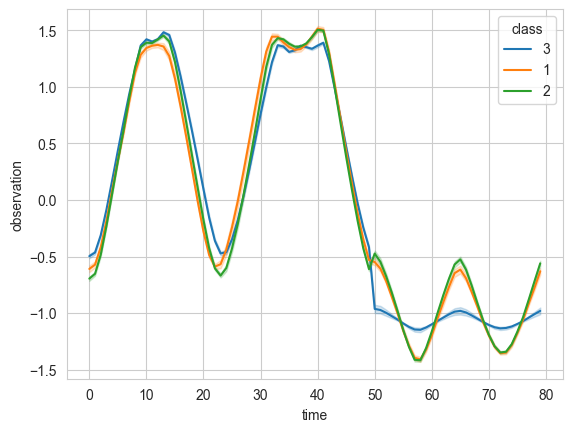

In [145]:
df = pd.DataFrame(np.squeeze(X_train))
df["class"] = y_train
df_melt = df.melt(value_name="observation", var_name="time", id_vars="class")
sns.lineplot(df_melt, x="time", y="observation", estimator="mean", hue="class")
plt.show()

## Normalization

In [7]:
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

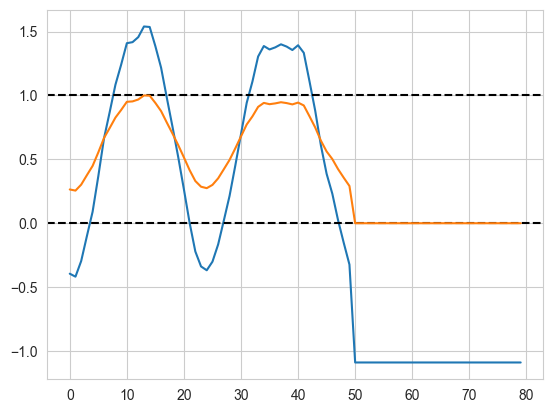

In [150]:
# check that the means and std of each series are 0 and 1
X_train_scaled.min(axis=(1, 2)), X_train_scaled.max(axis=(1, 2))
plt.plot(X_train[0].ravel())
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="black", linestyle="--")
plt.plot(X_train_scaled[0].ravel())

## Classification

### KNN

In [151]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [152]:
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance="dtw")

In [153]:
%%time
knn.fit(X_train_scaled, y_train)
knn.score(X_test_scaled, y_test)

CPU times: user 1.52 s, sys: 9.37 ms, total: 1.53 s
Wall time: 1.54 s


0.6486486486486487

### Shapelet transform

In [94]:
from sktime.classification.shapelet_based import ShapeletTransformClassifier

In [97]:
st = ShapeletTransformClassifier()

In [99]:
%%time
st.fit(X_train_scaled, y_train)
st.score(X_test_scaled, y_test)

CPU times: user 1min 44s, sys: 861 ms, total: 1min 45s
Wall time: 1min 47s


0.6936936936936937

### Feature-based classification

In [165]:
from sktime.pipeline import make_pipeline
from sktime.transformations.series.summarize import SummaryTransformer
from sklearn.linear_model import LogisticRegressionCV
from sktime.pipeline import sklearn_to_sktime

In [166]:
pipe = make_pipeline(SummaryTransformer(), sklearn_to_sktime(LogisticRegressionCV()))

In [167]:
%%time
pipe.fit(X_train_scaled, y_train)
pipe.score(X_test_scaled, y_test)

/Users/francesco/miniconda3/envs/evaltime/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/francesco/miniconda3/envs/evaltime/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

CPU times: user 1.8 s, sys: 18.9 ms, total: 1.82 s
Wall time: 1.84 s


0.7117117117117117

### Neural networks

#### CNN

In [12]:
from sktime.classification.deep_learning import CNNClassifier
import tensorflow as tf
from tensorflow import keras

##### Using sktime
easier, but there is no option to monitor the val loss to check for overfitting

In [176]:
cnn = CNNClassifier(
    n_epochs=10,
    batch_size=16,
    n_conv_layers=2,
    metrics=["accuracy"],
    random_state=42,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="loss")],
)

In [177]:
%%time
cnn.fit(X_train_scaled, y_train)
cnn.score(X_test_scaled, y_test)

7/7 [==============================] - 0s 809us/step
CPU times: user 1.16 s, sys: 73.6 ms, total: 1.23 s
Wall time: 1.02 s


0.6846846846846847

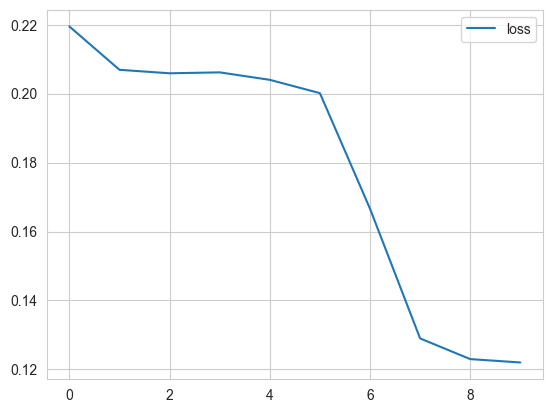

In [181]:
sns.lineplot(cnn.history.history["loss"], label="loss")
plt.show()

##### Using keras

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Activation, Conv1D, BatchNormalization
from keras.callbacks import EarlyStopping

In [22]:
def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()

    model.add(
        Conv1D(
            filters=16, kernel_size=8, activation="relu", input_shape=(n_timesteps, 1)
        )
    )
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=32, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(n_outputs, activation="sigmoid"))
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"],
    )

    return model

In [23]:
X_train_cnn = np.swapaxes(X_train_scaled, 1, 2)
X_test_cnn = np.swapaxes(X_test_scaled, 1, 2)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train)), 1
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

TIMESTEPS:  80
N. LABELS:  3


In [24]:
cnn = build_simple_cnn(n_timesteps, n_outputs)
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 73, 16)            144       
                                                                 
 batch_normalization_6 (Batc  (None, 73, 16)           64        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 73, 16)            0         
                                                                 
 dropout_6 (Dropout)         (None, 73, 16)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 69, 32)            2592      
                                                                 
 batch_normalization_7 (Batc  (None, 69, 32)           128       
 hNormalization)                                      

In [25]:
es = EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True)
callbacks = [es]

In [26]:
%%time
cnn.fit(
    X_train_cnn,
    y_train,
    epochs=1000,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/1000
20/20 [==============================] - 1s 13ms/step - loss: 1.1914 - accuracy: 0.3065 - val_loss: 1.0967 - val_accuracy: 0.4135
Epoch 2/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.1470 - accuracy: 0.3194 - val_loss: 1.0979 - val_accuracy: 0.4211
Epoch 3/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.0976 - accuracy: 0.3548 - val_loss: 1.0977 - val_accuracy: 0.4211
Epoch 4/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.0773 - accuracy: 0.3839 - val_loss: 1.0974 - val_accuracy: 0.4211
Epoch 5/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.0452 - accuracy: 0.4290 - val_loss: 1.0972 - val_accuracy: 0.4211
Epoch 6/1000
20/20 [==============================] - 0s 6ms/step - loss: 1.0162 - accuracy: 0.5581 - val_loss: 1.0970 - val_accuracy: 0.4211
Epoch 7/1000
20/20 [==============================] - 0s 5ms/step - loss: 0.9773 - accuracy: 0.6323 - val_loss: 1.0968 - val_accuracy: 0.4211
Epoch

In [27]:
summary = pd.DataFrame(cnn.history.history)
summary

,loss,accuracy,val_loss,val_accuracy
0,1.191388,0.306452,1.096732,0.413534
1,1.147037,0.319355,1.097916,0.421053
2,1.097580,0.354839,1.097728,0.421053
3,1.077296,0.383871,1.097443,0.421053
4,1.045218,0.429032,1.097198,0.421053
...,...,...,...,...
277,0.578882,0.725806,0.601682,0.789474
278,0.587477,0.722581,0.601501,0.774436
279,0.572366,0.735484,0.601664,0.774436
280,0.567216,0.745161,0.599604,0.774436


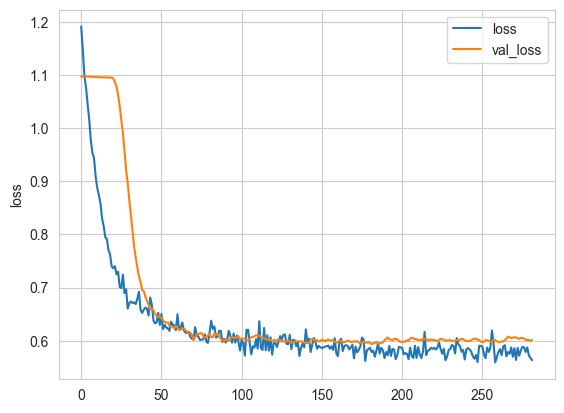

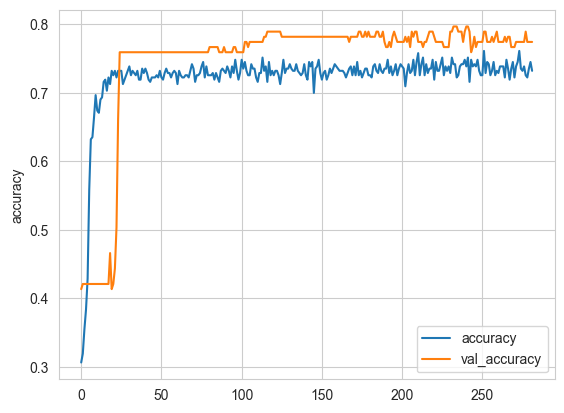

In [28]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [29]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)
print("Accuracy %s" % accuracy_score(y_test, y_pred))

4/4 [==============================] - 0s 2ms/step
Accuracy 0.6936936936936937


#### LSTM

##### Using keras

In [30]:
from keras.layers import LSTM

In [38]:
def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256, input_shape=(n_timesteps, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs, activation="sigmoid"))

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"],
    )

    return model

In [42]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
callbacks = [es]

In [43]:
lstm = build_lstm(n_timesteps, n_outputs)
lstm.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                16448     
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 280,835
Trainable params: 280,835
Non-trainable params: 0
_________________________________________________________________


In [44]:
lstm.fit(
    X_train_cnn,
    y_train,
    epochs=20,
    batch_size=16,
    callbacks=callbacks,
    validation_split=0.3,
)

Epoch 1/20
20/20 [==============================] - 3s 94ms/step - loss: 1.0353 - accuracy: 0.6032 - val_loss: 0.9257 - val_accuracy: 0.7594
Epoch 2/20
20/20 [==============================] - 2s 80ms/step - loss: 0.8144 - accuracy: 0.7097 - val_loss: 0.6666 - val_accuracy: 0.7218
Epoch 3/20
20/20 [==============================] - 2s 79ms/step - loss: 0.7327 - accuracy: 0.7194 - val_loss: 0.6744 - val_accuracy: 0.7669
Epoch 4/20
20/20 [==============================] - 2s 81ms/step - loss: 0.6548 - accuracy: 0.7258 - val_loss: 0.6765 - val_accuracy: 0.7594
Epoch 5/20
20/20 [==============================] - 2s 80ms/step - loss: 0.6985 - accuracy: 0.7161 - val_loss: 0.6403 - val_accuracy: 0.7744
Epoch 6/20
20/20 [==============================] - 2s 78ms/step - loss: 0.6481 - accuracy: 0.7226 - val_loss: 0.5922 - val_accuracy: 0.7594
Epoch 7/20
20/20 [==============================] - 2s 80ms/step - loss: 0.6248 - accuracy: 0.7323 - val_loss: 0.5927 - val_accuracy: 0.7594
Epoch 8/20
20

In [47]:
summary = pd.DataFrame(lstm.history.history)
summary

,loss,accuracy,val_loss,val_accuracy
0,1.035308,0.603226,0.925736,0.759399
1,0.814438,0.709677,0.666600,0.721804
2,0.732656,0.719355,0.674392,0.766917
3,0.654835,0.725806,0.676517,0.759399
4,0.698482,0.716129,0.640328,0.774436
5,0.648141,0.722581,0.592248,0.759399
6,0.624849,0.732258,0.592679,0.759399
7,0.641873,0.732258,0.592303,0.759399
8,0.628963,0.732258,0.644724,0.759399
9,0.654471,0.722581,0.598959,0.774436


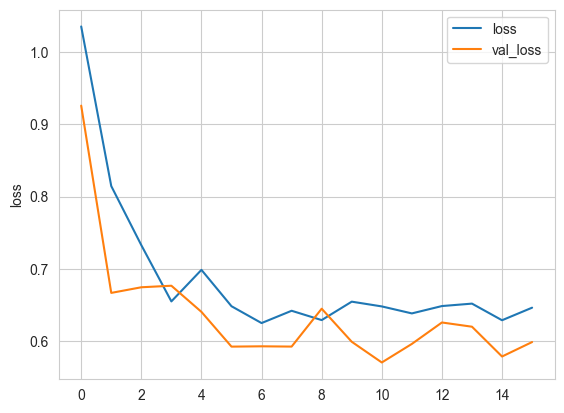

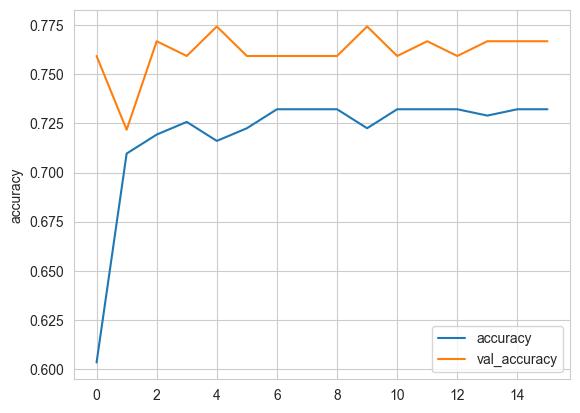

In [48]:
sns.lineplot(summary["loss"], label="loss")
sns.lineplot(summary["val_loss"], label="val_loss")
plt.show()

sns.lineplot(summary["accuracy"], label="accuracy")
sns.lineplot(summary["val_accuracy"], label="val_accuracy")
plt.show()

In [49]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print("Accuracy %s" % accuracy_score(y_test, y_pred))

4/4 [==============================] - 0s 35ms/step
Accuracy 0.6846846846846847


### Rocket

In [50]:
from sktime.classification.kernel_based import RocketClassifier

In [67]:
rocket = RocketClassifier(rocket_transform="minirocket", n_jobs=-1)

In [69]:
%%time
rocket.fit(X_train_scaled, y_train)
rocket.score(X_test_scaled, y_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
CPU times: user 6.44 s, sys: 336 ms, total: 6.77 s
Wall time: 5.84 s


0.6936936936936937

### Muse

In [55]:
from sktime.classification.dictionary_based import MUSE

In [56]:
muse = MUSE()

In [57]:
%%time
muse.fit(X_train_scaled, y_train)
muse.score(X_test_scaled, y_test)

CPU times: user 14.8 s, sys: 688 ms, total: 15.5 s
Wall time: 14.2 s


0.6756756756756757

### Cif

In [58]:
from sktime.classification.interval_based import CanonicalIntervalForest

In [59]:
cif = CanonicalIntervalForest(n_estimators=10)

In [60]:
%%time
cif.fit(X_train_scaled, y_train)
cif.score(X_test_scaled, y_test)

CPU times: user 20.3 s, sys: 194 ms, total: 20.4 s
Wall time: 20.7 s


0.6486486486486487